# Heart Rate Estimation

Seismocardiography ([SCG](https://www.ncbi.nlm.nih.gov/pubmed/24111357)) is a very promising technique to measure the Heart Rate (HR) and Respiratory Rate (RR) with a detector positioned above the sternum. It is generally based on accelerometer and gyroscope readings or a combination of them. 

Ballistocardiography ([BCG](https://en.wikipedia.org/wiki/Ballistocardiography)) is an another technique to estimate heart and respiratory rate with a combination of both an accelerometer and a gyroscope. It is an indirect evaluation of HR and RR since the contact between the device and the body of the subject is not required (e.g., the accelerometer platform can be mounted under the slats of the bed).   
  
MuSe (Multi-Sensor miniaturized, low-power, wireless [IMU](https://en.wikipedia.org/wiki/Inertial_measurement_unit)) is an Inertial Measurement Unit (IMU) provided by [221e](https://www.221e.com). In the context of this project, it allows to record the inertial data necessary for the estimation of SCG and BCG.

The goal of this assignment is to estimate the heart rate of an healthy subject, given the linear acceleration and angular velocity measurements recorded by using the aforementioned MuSe platform.

The study must be performed on two datasets: the first is the compulsory one (`center_sternum.txt`), while the second is left at the discretion of the group, among those made available for the assignment.

*Remember that normal heart rate is around [40-100] bpm.*


## Data

The data is provided in `.txt` files. During this study, two healthy subjects were involved with their informed consent. The first dataset was recorded on one subject, while all the other datasets were recorded on the second subject. 

This is the first mandatory file:

* `center_sternum.txt`: MuSe placed on the center of the sternum. The subject was lying supine on his left and right side, respectively. 


Choose one of the following files in order to complete the task.

* `1_Stave_supine_static.txt`: Sensor placed on a bed stave, under the mattress at the level of the chest. The subject was lying supine on his left and right side. 
* `2_Mattress_supine.txt`: Sensor placed on the mattress, near one corner but not under the pillow. The subject laid in the same position as above. 
* `3_Subject_sitting_chair.txt`: Sensor placed on the desk: the subject, sitting on a chair, leaned forearms and hands on the desk. 
* `4_Chest_sweater.txt`: Sensor placed on the subject chest directly on a sweater. 
* `5_Under_chair.txt`: Subject sitting on a chair, sensor placed under the seat of the chair. 

All `.txt` files have 16 columns, containing: 

* Log Freq stands for the acquisition in Hz (i.e., sampling interval is constant).
* AccX, AccY, AccZ are the measured magnitude of linear acceleration along each axis.
* GyroX, GyroY, GyroZ are the measured magnitude of angular velocity along each axis.
* MagnX, MagnY, MagnZ are the measured magnitude of magnetic field along each axis.
* qw, qi, qj, qk are the quaternion components, representing the spatial orientation of the Muse system.

Each dataset includes, in addition to the data, one file containing the adopted configuration of the MuSe(`config_1.txt` for the first measurement, and in `config_5.txt` for the other measurement).
 


## Assignment



1. Data preparation:

    1.1. Load the txt files and select only the columns you are interested in, in order to do a complete data analysis (e.g. Log Freq, AccX, ... )
    
    1.2. Plot selected data as a function of time and choose a proper time window over which to perform the analysis. Pay attention on the time representation and the measurement unit.
    
    1.3. In order to do a proper job, decide whether to consider some particular axis or some combination of them as well as derived features for the next step of the task. Motivate your choice.  


    
2. Time and frequency analysis:

    2.1. Statistical analysis: provide a statistical description of the chosen dataset. Statistical descriptors includes for example mean, median, variance, standard deviation, 25th and 75th percentiles, and correlation coefficients. Investigate what could be the most interesting descriptors for this type of data, motivating the choices.
    
    2.2. Fourier Analysis: Perform a frequency analysis of the data. Look at the spectrum and explain what you see. Use the Fourier analysis to properly design the filters in the following step. 



3. Filter:
    
    Implement your own filter, trying to extrapolate the heart rate signal. Hints:
    
    (a) Directly from Fourier Analysis, look for the most interesting frequency band.
    
    (b) Choose the appropriate Lowpass/Bandpass/Highpass filter.
        
    (c) Explore another methods by yourselves.
    
    Remember to always motivate your choice.
    
    
4. Metrics:

    4.1. Heart Beat Per Minute (BPM): extrapolate BPM, make an histogram of the result. Does it follow a particular distribution? 
    
    4.2. Heart Rate Variability (HRV): extrapolate HRV, explain why this parameter is important, and plot the results.


5. **Optional**: Elaborate a simple algorithm to extrapolate the heart rate even when the filter fails (e.g. look for a particular threshold...).  



6. Conclusion: 

    Summarise the obtained results, and specifically make a comparison between the two files analysed. Highlight the limitations and the critical issues encountered during the work, motivating the most relevant contribution given by your solution.

# GROUP 9 : 
SHAHLA SADEGHZADEHDARANDASH - SHAYAN SHARIFI - ANAÏS BATTUT - ANAÏS FRAGNE


In [486]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import seaborn as sns
from scipy import fft, signal, interpolate, stats, fftpack, linalg as la
from scipy.signal import butter, lfilter, freqz
from scipy.signal import argrelextrema
from scipy.signal.waveforms import gausspulse

%matplotlib inline

# 1. Data preparation : center_sternum.txt

## 1.1 
Load the txt files and select only the columns you are interested in, in order to do a complete data analysis (e.g. Log Freq, AccX, ... )

Display of the data of the "center_sternum.txt" file:

<u>Timestamp</u> : the time of the measurement    
<u>Acc[X, Y, Z]</u> : linear acceleration vector    
<u>Gyro[X, Y, Z]</u> : angular velocity vector    
<u>Magn[X, Y, Z]</u> : magnetic field vector    
<u>q[w, i, j, k]</u> : spatial orientation of the Muse system

We don't care about the spatial orientation of the Muse system in this case because the Muse is placed on the center of the sternum and does not move. 

In [53]:
data = pd.read_csv('center_sternum.txt', sep='\t')
data = data.iloc[:, 2:12]
data

,Timestamp,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ
0,1576222772,947.086,435.662,70.638,-6.824428,-14.244280,1.404580,-454,-490,-178
1,1576222772,969.168,387.777,88.877,6.183206,-12.290080,-7.969466,-454,-490,-177
2,1576222772,989.603,380.335,78.751,11.709920,-4.961832,-7.450382,-454,-490,-177
3,1576222772,954.894,418.033,88.328,17.877860,2.519084,-5.984733,-454,-492,-176
4,1576222772,972.096,427.732,99.857,25.221370,5.404580,4.015267,-454,-492,-176
...,...,...,...,...,...,...,...,...,...,...
16501,1576222847,958.493,291.092,-54.290,1.664122,2.305344,-0.671756,-494,-449,-126
16502,1576222847,954.650,288.042,-49.654,1.480916,2.488550,-0.702290,-494,-450,-125
16503,1576222847,967.338,290.482,-63.867,1.114504,3.374046,-0.900763,-494,-450,-125
16504,1576222847,965.630,300.852,-56.242,0.702290,3.664122,-1.587786,-495,-448,-124


`config_1.txt` : adopted configuration of the MuSe    
We need ton apply this config file to our data

In [100]:
#config_1.txt data
#gyro : x,y,z 
gyro = np.array([-2.242224, 2.963463, -0.718397])
#acc : x, y, z, offset
acc = np.array([[1.000966, -0.002326418,-0.0006995499,-3.929942],
                [-0.002326379, 0.9787045, -0.001540918, -13.74679],
                [-0.0006995811, -0.001540928 ,1.00403 ,60.67546]])
#magn : x, y, z, offset
magn = np.array([[0.9192851, -0.02325168, 0.003480837, -95.67974],
                 [-0.02325175, 0.914876, 0.004257396, -244.9142],
                 [0.003481006, 0.004257583, 0.8748001, 17.71132]])

# Function that apply the configuration to the data (modify the data values)
def apply_config(conf, name, offset):
    #create the right column name
    column = np.array([name + i for i in ['X', 'Y', 'Z']])
    n = len(data)
    
    #for each line of the dataset, we apply the conf and the offset data = data * conf + offset
    #if Gyro we need conf * data
    if (name=="Gyro"):
        for k in range(n):
            data.loc[k, column] = conf * data.loc[k, column]
    #else we need conf.dot(data)
    else:
        for k in range(n):
            data.loc[k, column] = conf.dot(data.loc[k,column]) + offset



apply_config(gyro, "Gyro", 0) 
apply_config(acc[:, :3], "Acc", acc[:, 3])
apply_config(magn[:, :3], "Magn", magn[:, 3])
#print(data[2000:3000])
data

,Timestamp,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ
0,1576222772,934.890619,361.013611,250.363721,76.931331,-370.714036,-0.520763,-574.347095,-1018.725952,-84.830242
1,1576222772,957.326092,315.888315,268.995272,-69.702877,-319.855069,2.954764,-574.338956,-1018.715940,-84.160699
2,1576222772,977.892845,308.817818,258.737161,-132.005163,-129.133994,2.762308,-574.338956,-1018.715940,-84.160699
3,1576222772,942.804781,344.352988,268.332235,-201.535948,65.560337,2.218903,-574.213538,-1020.240496,-83.511181
4,1576222772,959.966496,353.275775,279.921161,-284.318856,140.656717,-1.488703,-574.213538,-1020.240496,-83.511181
...,...,...,...,...,...,...,...,...,...,...
16501,1576222847,947.581227,225.970103,124.550401,-18.759539,59.997654,0.249061,-607.463923,-984.401082,-49.929061
16502,1576222847,943.738131,223.115992,129.264624,-16.694269,64.765675,0.260381,-607.397145,-985.158354,-49.269531
16503,1576222847,956.476307,225.381246,114.841273,-12.563731,87.811122,0.333968,-607.397145,-985.158354,-49.269531
16504,1576222847,954.676441,235.080057,122.515414,-7.916870,95.360485,0.588688,-608.284681,-983.555134,-48.588102


## 1.2
Plot selected data as a function of time and choose a proper time window over which to perform the analysis. Pay attention on the time representation and the measurement unit.

Total acquisition time : 75.0 s


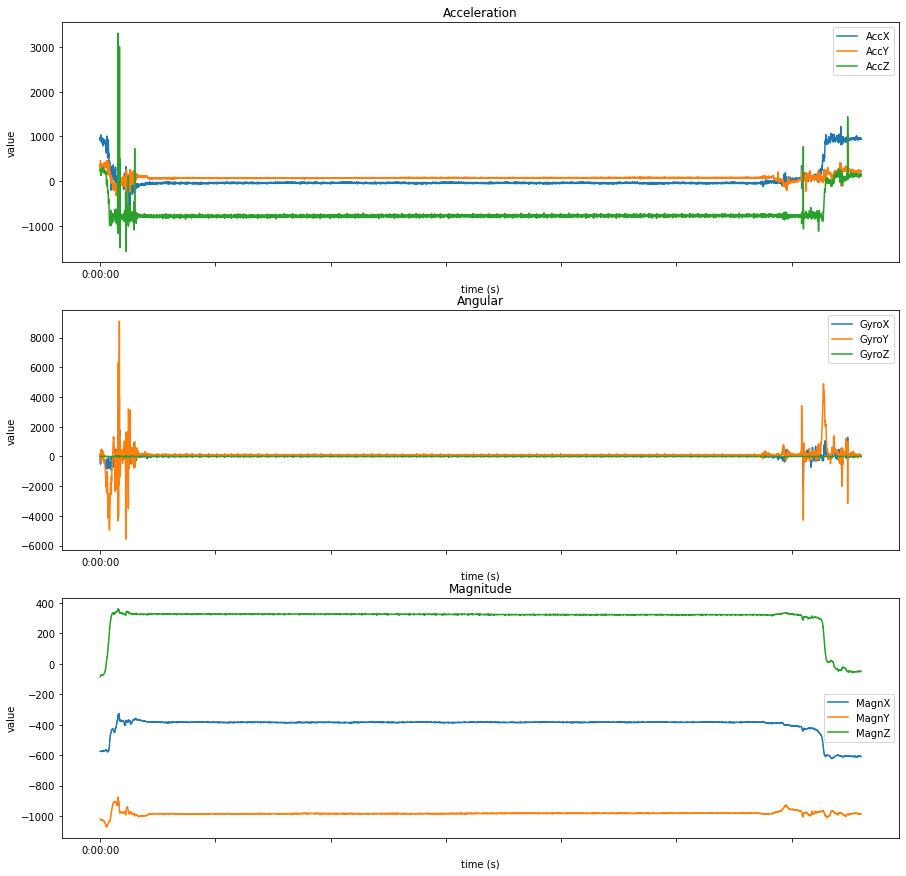

In [469]:
#time of the data acquisition
t_min = datetime.fromtimestamp(data['Timestamp'].min())
t_max = datetime.fromtimestamp(data['Timestamp'].max())
t_total = np.abs(t_max - t_min).total_seconds()
print("Total acquisition time : %s s" % t_total)

n = len(data)
#the number of acquisition in the data file
t = np.arange(0, n, 1)

#Function that set the tick labels in a format we understand (in seconds)
def format_func(value, tick_number):
    if (value >= 0) & (value < n):
        ticks = datetime.fromtimestamp(data['Timestamp'][value])
        ticks = ticks - t_min #we start the time from 0
        return ticks

# We plot the components for each measurements as a function of time
fig, axs = plt.subplots(3, figsize=(15, 15))

for i, j in zip(range(4), ['Acc', 'Gyro', 'Magn']):
    index = np.array([j + i for i in ['X', 'Y', 'Z']])
    for n in range(3):
        axs[i].plot(t, data[index[n]], label=index[n])
    axs[i].legend(loc="best")
    axs[i].xaxis.set_major_formatter(plt.FuncFormatter(format_func)) # transform timestamp in seconds
    axs[i].set_xlabel("time (s)")
    axs[i].set_ylabel("value")
 
axs[0].title.set_text("Acceleration")
axs[1].title.set_text("Angular")
axs[2].title.set_text("Magnitude")



We can see some variations at the begging and at the end of the data that are maybe due to the installation/desinstallation of the MuSe. We have decided to keep only the signal where these variations are not present because they could disturb our results.   
According to the major ticks, the variations are not present from 0:00:11 to 0:00:62

In [56]:
#Let's find the index for the time 0:00:11 and 0:00:62
print(f"tmin:{t_min}")
t_search_min = t_min + timedelta(seconds=11)
t_search_max = t_min + timedelta(seconds=62)
print(f"t_search_min:{t_search_min}")
print(f"t_search_max:{t_search_max}")
      
#From datetime -> to timestamp
ts_min = datetime.timestamp(t_search_min)
ts_max = datetime.timestamp(t_search_max)
print(f"ts_min:{ts_min}")
print(f"ts_max:{ts_max}")

tmin:2019-12-13 08:39:32
t_search_min:2019-12-13 08:39:43
t_search_max:2019-12-13 08:40:34
ts_min:1576222783.0
ts_max:1576222834.0


In [113]:
#We reduce the data
data_r = data[(data["Timestamp"] >= ts_min) & (data["Timestamp"] <= ts_max)]
data_reset_index = data_r.reset_index(drop=True)

#we check if the data start at the right time
t_min = data_r['Timestamp'].min()
t_max = data_r['Timestamp'].max()
print("Are t_min and ts_min equal", np.allclose(ts_min, t_min))
print("Are t_max and ts_max equal", np.allclose(ts_max, t_max))
data_r

Are t_min and ts_min equal True
Are t_max and ts_max equal True


,Timestamp,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ
2394,1576222783,-46.361879,65.399368,-782.348434,27.709043,98.936515,0.283023,-384.327424,-983.881629,323.442990
2395,1576222783,-41.109819,67.434693,-785.147755,26.504304,92.181813,0.186795,-384.327424,-983.881629,323.442990
2396,1576222783,-48.623588,67.377307,-760.991411,28.397469,97.744496,0.141512,-384.286732,-983.831568,326.790704
2397,1576222783,-36.738251,71.340867,-783.015140,24.439035,100.525838,0.118870,-384.286732,-983.831568,326.790704
2398,1576222783,-50.414882,67.991320,-754.940127,20.652704,102.115187,0.067926,-384.286732,-983.831568,326.790704
...,...,...,...,...,...,...,...,...,...,...
13701,1576222834,-41.088861,80.342556,-781.753086,14.456896,95.360485,0.339628,-384.578261,-980.832516,322.143954
13702,1576222834,-40.755868,77.826637,-756.860608,21.341131,103.704536,0.254721,-385.348517,-980.763864,322.805358
13703,1576222834,-27.949164,70.149262,-798.401138,17.554800,103.307206,0.226419,-385.348517,-980.763864,322.805358
13704,1576222834,-33.234220,75.519432,-776.560249,17.038477,111.651230,0.277363,-385.348517,-980.763864,322.805358


Let's plot again the measurements to check if there are any variations left.

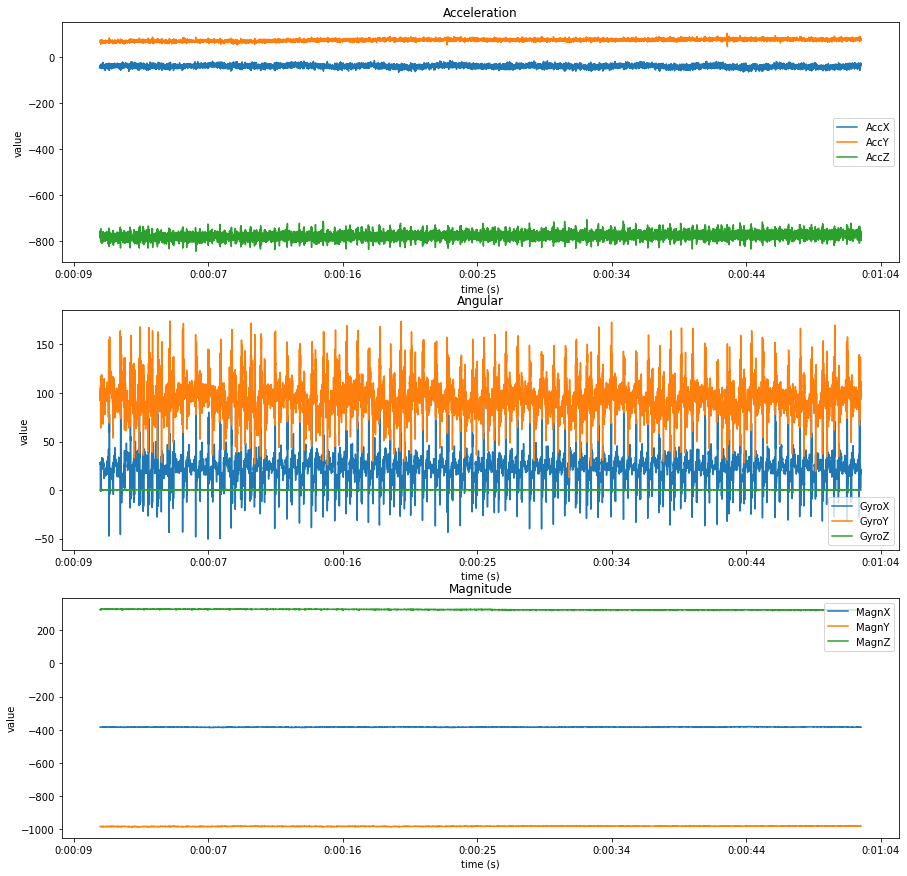

In [114]:
#The number of acquisition in the data reduce

t = np.arange(data_r.index.min(), data_r.index.max()+1, 1)

t_min = datetime.fromtimestamp(data['Timestamp'].min())
t_min_r = datetime.fromtimestamp(data_r['Timestamp'].min())
#to set the ticks in a format we understand (in seconds)
def format_func(value, tick_number):
    if (value > 2000) & (value < 14000):
        ticks = datetime.fromtimestamp(data_r['Timestamp'][value])
        ticks = ticks - t_min_r
        return ticks
    elif (value >= 14000) | (value <= 2000):
        ticks = datetime.fromtimestamp(data['Timestamp'][value])
        ticks = ticks - t_min
        return ticks

fig, axs = plt.subplots(3, figsize=(15, 15))
for i, j in zip(range(4), ['Acc', 'Gyro', 'Magn']):
    index = np.array([j + i for i in ['X', 'Y', 'Z']])
    for n in range(3):
        axs[i].plot(t, data_r[index[n]], label=index[n])
        
    axs[i].legend(loc="best")
    axs[i].xaxis.set_major_formatter(plt.FuncFormatter(format_func))
    axs[i].set_xlabel("time (s)")
    axs[i].set_ylabel("value")
    
axs[0].title.set_text("Acceleration")
axs[1].title.set_text("Angular")
axs[2].title.set_text("Magnitude")


## 1.3
In order to do a proper job, decide whether to consider some particular axis or some combination of them as well as derived features for the next step of the task. Motivate your choice. 

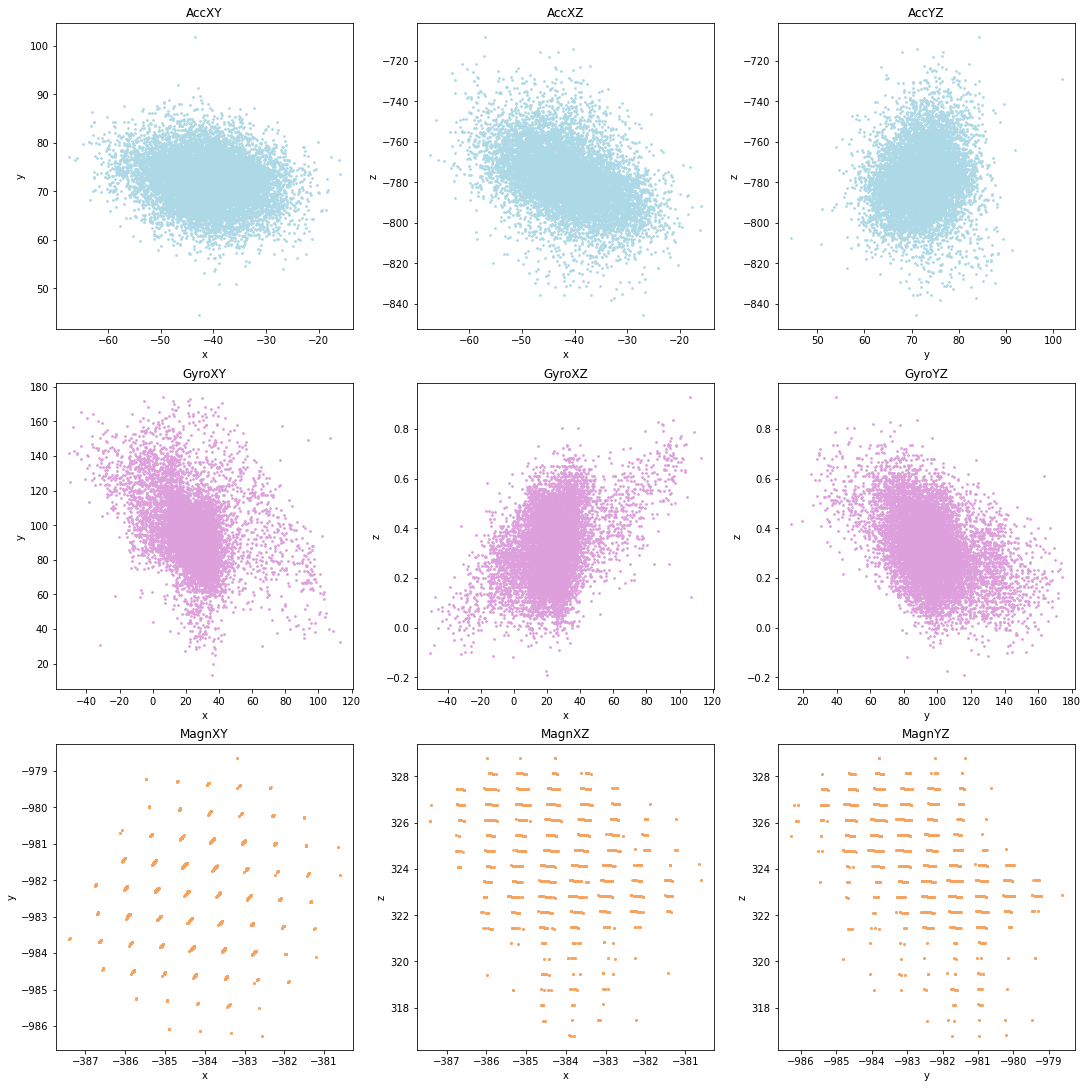

In [117]:
#First, let's see if there are any correlations between x, y, z of each measurements.
data_acc = data_reset_index.iloc[:, 1:4]
data_gyro = data_reset_index.iloc[:, 4:7]
data_magn = data_reset_index.iloc[:, 7:10]

#Correlation between x, y, z of acceleration
fig, axs = plt.subplots(3,3, figsize=(15, 15), constrained_layout = True)

# Function that plot the correlation features for each measurement
def plot_corr(data_, line, colors):
    n = len(data_.columns[0])
    axs[line, 0].scatter(data_.iloc[:,0], data_.iloc[:,1], c=colors, s=3)
    axs[line, 0].set_xlabel("x")
    axs[line, 0].set_ylabel("y")
    axs[line, 0].set_title(data_.columns[0] + data_.columns[1][n-1])
    axs[line, 1].scatter(data_.iloc[:,0], data_.iloc[:,2], c=colors, s=3)
    axs[line, 1].set_xlabel("x")
    axs[line, 1].set_ylabel("z")
    axs[line, 1].set_title(data_.columns[0] + data_.columns[2][n-1])
    axs[line, 2].scatter(data_.iloc[:,1], data_.iloc[:,2], c=colors, s=3)
    axs[line, 2].set_xlabel("y")
    axs[line, 2].set_ylabel("z")
    axs[line, 2].set_title(data_.columns[1] + data_.columns[2][n-1])
    
plot_corr(data_acc, 0, 'lightblue')
plot_corr(data_gyro, 1, 'plum')
plot_corr(data_magn, 2, 'sandybrown')


Seeing those plots, we don't see any significant correlation between the features, thus we need to create another new component that group all the features of each measurement.   
To do so, we decided to compute the norm of each measurement :     
$$ x_{norm} = {\sqrt{x_i^2 + y_i^2 + z_i^2} } $$    
We add an extra component (the norm component) to get a combination of the three other components x, y, z directly. Then we hope to work on only one component instead of three to do a proper job.    
Let's prove it with PCA analysis.

In [118]:
#We calculate the norm of data_acc, data_gyro and data_magn
norm_acc = [la.norm(data_acc.iloc[i,:]) for i in range(len(data_acc))]
data_acc['AccN'] = norm_acc
norm_gyro = [la.norm(data_gyro.iloc[i,:]) for i in range(len(data_gyro))]
data_gyro['GyroN'] = norm_gyro
norm_magn = [la.norm(data_magn.iloc[i,:]) for i in range(len(data_magn))]
data_magn['MagnN'] = norm_magn
#Just to get an idea of what components we have now :
data_acc

,AccX,AccY,AccZ,AccN
0,-46.361879,65.399368,-782.348434,786.444896
1,-41.109819,67.434693,-785.147755,789.109911
2,-48.623588,67.377307,-760.991411,765.514129
3,-36.738251,71.340867,-783.015140,787.116210
4,-50.414882,67.991320,-754.940127,759.670373
...,...,...,...,...
11307,-41.088861,80.342556,-781.753086,786.944158
11308,-40.755868,77.826637,-756.860608,761.942259
11309,-27.949164,70.149262,-798.401138,801.964121
11310,-33.234220,75.519432,-776.560249,780.931187


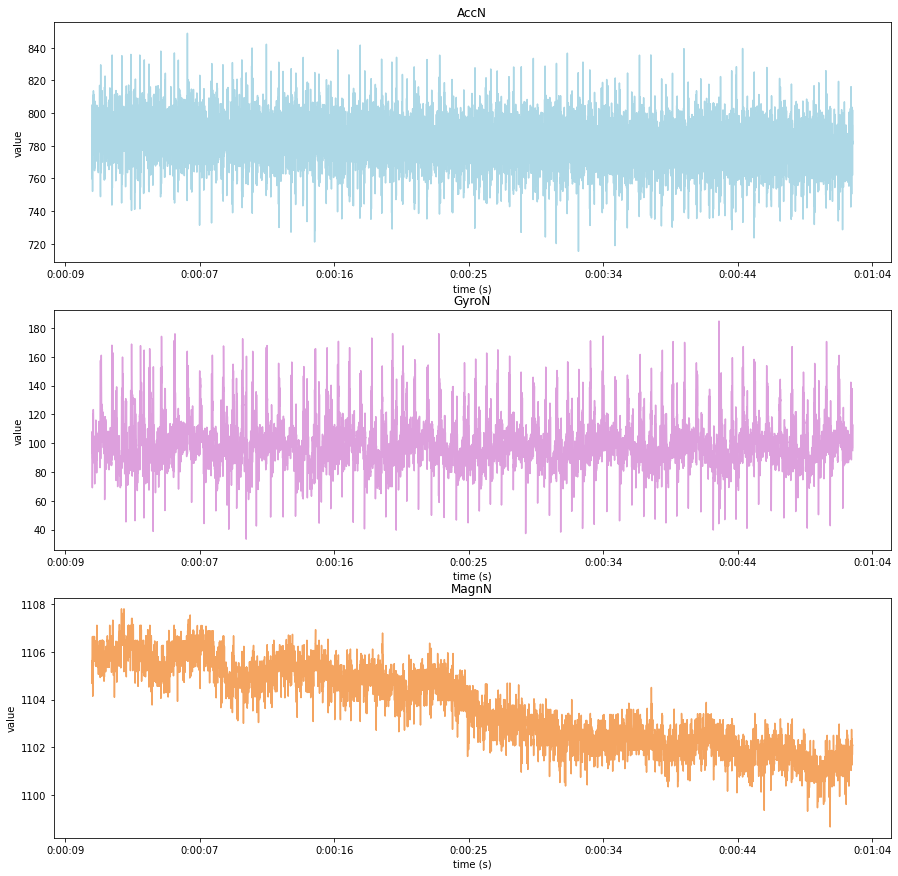

In [119]:
#Creation of a panda DataFrame with the timestamp and the norm
d = {'Timestamp': data_r['Timestamp'], 'AccN': norm_acc, 'GyroN': norm_gyro, 'MagnN' : norm_magn}
data_norm =pd.DataFrame(d)

t = np.arange(data_norm.index.min(), data_norm.index.max()+1, 1)
t_min = datetime.fromtimestamp(data['Timestamp'].min())
t_min_r = datetime.fromtimestamp(data_norm['Timestamp'].min())

#Function that set the ticks in a format we understand (in seconds)
def format_func(value, tick_number):
    if (value > 2000) & (value < 14000):
        ticks = datetime.fromtimestamp(data_r['Timestamp'][value])
        ticks = ticks - t_min_r
        return ticks
    elif (value >= 14000) | (value <= 2000):
        ticks = datetime.fromtimestamp(data['Timestamp'][value])
        ticks = ticks - t_min
        return ticks

# Plot of the norm of each measurement (acc, gyro, magn):
fig, axs = plt.subplots(3, figsize = (15,15))
for i, j, c in zip(range(4), ['AccN', 'GyroN', 'MagnN'], ['lightblue', 'plum', 'sandybrown']):
    axs[i].plot(t, data_norm[j], c=c)
    axs[i].set_xlabel("time (s)")
    axs[i].set_ylabel("value")
    axs[i].set_title(j)
    axs[i].xaxis.set_major_formatter(plt.FuncFormatter(format_func))

We want to see if it is better to keep the variables X, Y and Z or to keep the norm. For that, we are going to perform a PCA to see what is the feature that keeps the most variability

In [120]:
# Function that use the Singular Value Decomposition to get the eigenvalues and the eigenvectors of each measurements
def pca(data):
    U, S, Vt = la.svd(data)
    n = len(data)
    l = S**2 / (n-1)
    V = U
    Lambda = np.diag(l)
    Lambdat = Lambda.trace()
    print("By selecting",data.columns[-1] ,", we retain %.2f%% of the total variability" % ((Lambda[0,0]/Lambda.trace())*100))
    print("By selecting ",data.columns[-2] ,", we retain %.2f%% of the total variability" % ((Lambda[1,1]/Lambda.trace())*100))
    print("By selecting",data.columns[-3] ,", we retain %.2f%% of the total variability" % ((Lambda[2,2]/Lambda.trace())*100))
    print("By selecting ",data.columns[-4] ,", we retain %.2f%% of the total variability" % ((Lambda[3,3]/Lambda.trace())*100))

In [121]:
print("PCA ACC")
pca(data_acc)
print("PCA Gyro")
pca(data_gyro)
print("PCA Magn")
pca(data_magn)

PCA ACC
By selecting AccN , we retain 99.99% of the total variability
By selecting  AccZ , we retain 0.00% of the total variability
By selecting AccY , we retain 0.00% of the total variability
By selecting  AccX , we retain 0.00% of the total variability
PCA Gyro
By selecting GyroN , we retain 98.47% of the total variability
By selecting  GyroZ , we retain 1.50% of the total variability
By selecting GyroY , we retain 0.03% of the total variability
By selecting  GyroX , we retain 0.00% of the total variability
PCA Magn
By selecting MagnN , we retain 100.00% of the total variability
By selecting  MagnZ , we retain 0.00% of the total variability
By selecting MagnY , we retain 0.00% of the total variability
By selecting  MagnX , we retain 0.00% of the total variability


Thanks to the results, we see that for each of the measurement (Acceleration, Angular velocity, Magnetic field), the component of the normalization is the one that exhibit the largest variability, so we discard the three other components (x,y,z). The PCA gives the conclusion that we should project the data points to the norm component with almost no loss of information (dimension reduction).

# 2. Time and frequency analysis


## 2.1 
Statistical analysis: provide a statistical description of the chosen dataset. Statistical descriptors includes for example mean, median, variance, standard deviation, 25th and 75th percentiles, and correlation coefficients. Investigate what could be the most interesting descriptors for this type of data, motivating the choices.

In [122]:
data_norm.iloc[:,1:].describe()

,AccN,GyroN,MagnN
count,11312.000000,11312.000000,11312.000000
mean,782.642035,100.278203,1103.707475
std,14.233184,17.305266,1.712520
min,715.357246,33.396351,1098.650323
25%,775.089869,89.978998,1102.207307
50%,783.065670,98.424938,1103.711981
75%,790.918647,107.596311,1105.206850
max,848.908109,184.762197,1107.813337


To create the correlation coefficients, we will represent the correlation matrix:

[]

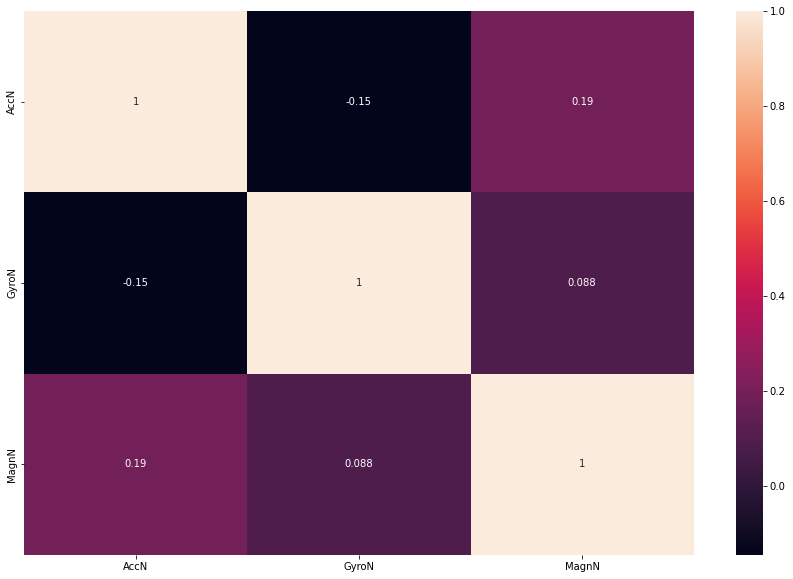

In [123]:
plt.subplots(figsize=(15, 10))
corr_matrix = data_norm.iloc[:,1:].corr()
sns.heatmap(corr_matrix, annot=True )
plt.plot()

According to the plot of our data, we can say that the mean and the standard deviation describe the most our data. Indeed, the standard deviation gives us an information about the width of our data and the mean gives us approximately the value of each measurement.    
The correlation matrix gives us the information that all the features have a small correlation between eachothers. That told us that we should keep the three features as they are all independent. 



## 2.2  Fourier Analysis: 
Perform a frequency analysis of the data. Look at the spectrum and explain what you see. Use the Fourier analysis to properly design the filters in the following step.

The peak frequency of the acceleration is: 0.01768033946251768
The peak frequency of the angular velocity is: 1.149222065063649
The peak frequency of the magnetic field is: 0.01768033946251768


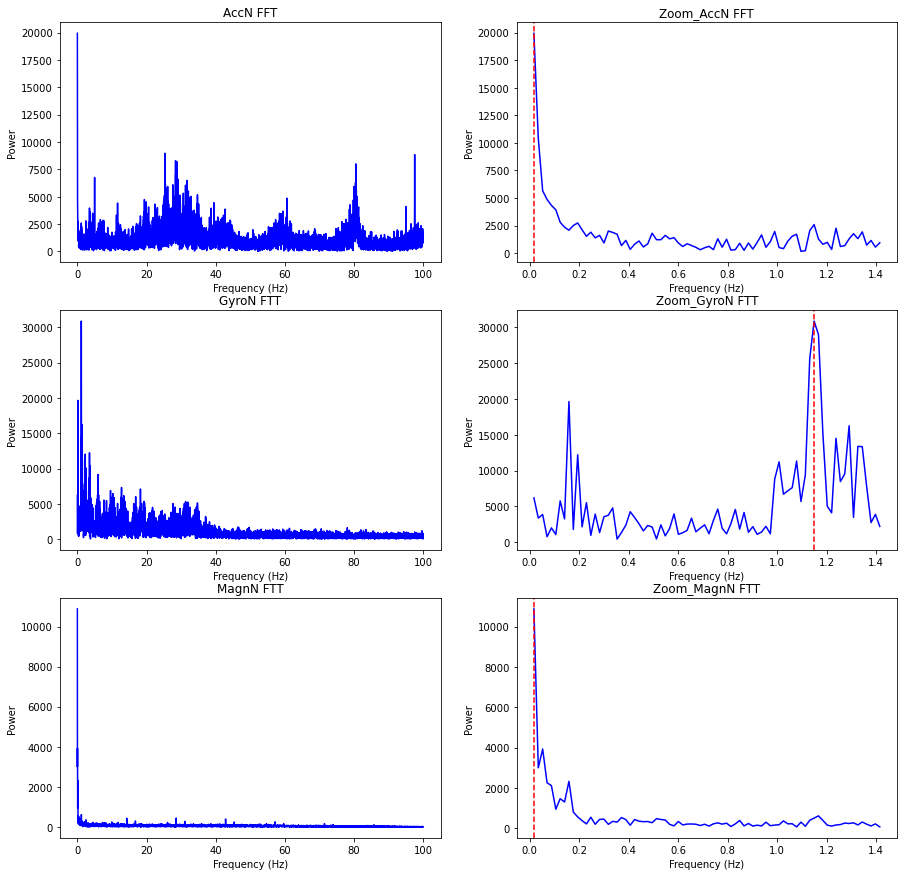

In [124]:
# Function that create the Fourier Transform of a signal
def fourier(sig):
    sig_fft = fftpack.fft(sig)
    power = np.abs(sig_fft)
    sample_freq = fftpack.fftfreq(len(sig), d=1/200)
    
    pos_mask = np.where(sample_freq > 0)
    freqs = sample_freq[pos_mask]
    powes = power[pos_mask]
    peak_freq = freqs[powes.argmax()]  # Finding freq. with peak power
    d = {'freq' : freqs, 'powes': powes}
    return pd.DataFrame(d), peak_freq, sample_freq

fourier_acc, peak_acc, freqs_acc = fourier(norm_acc)
fourier_gyro, peak_gyro, freqs_gyro = fourier(norm_gyro)
fourier_magn, peak_magn, freqs_magn = fourier(norm_magn)
print('The peak frequency of the acceleration is:',peak_acc)
print('The peak frequency of the angular velocity is:',peak_gyro)
print('The peak frequency of the magnetic field is:',peak_magn)

#Plot the frequency analysis of each measurement (left: real, right: zoom)
fig, axs = plt.subplots(3,2, figsize = (15,15))

for i,j,tit,k  in zip(range(3),[fourier_acc,fourier_gyro,fourier_magn],['AccN FFT','GyroN FTT', 'MagnN FTT'], [peak_acc,peak_gyro,peak_magn]):
    axs[i,0].plot(j['freq'], j['powes'], color='blue')
    axs[i,0].set_xlabel('Frequency (Hz)')
    axs[i,0].set_ylabel('Power')
    axs[i,0].set_title(tit)
    
    #We take only the 80 first values of our frequencies (ZOOM).
    axs[i,1].plot(j['freq'][:80], j['powes'][:80], color='blue')
    axs[i,1].axvline(k, linestyle='--', color='red')
    axs[i,1].set_xlabel('Frequency (Hz)')
    axs[i,1].set_ylabel('Power')
    axs[i,1].set_title('Zoom_'+tit)

Thanks to the Fourier analysis, we put in evidence the maximum frequency that represent the principal component of our signal, which is the value that affect the most the signal.

# 3 Filter
3.a - Directly from Fourier Analysis, look for the most interesting frequency band.

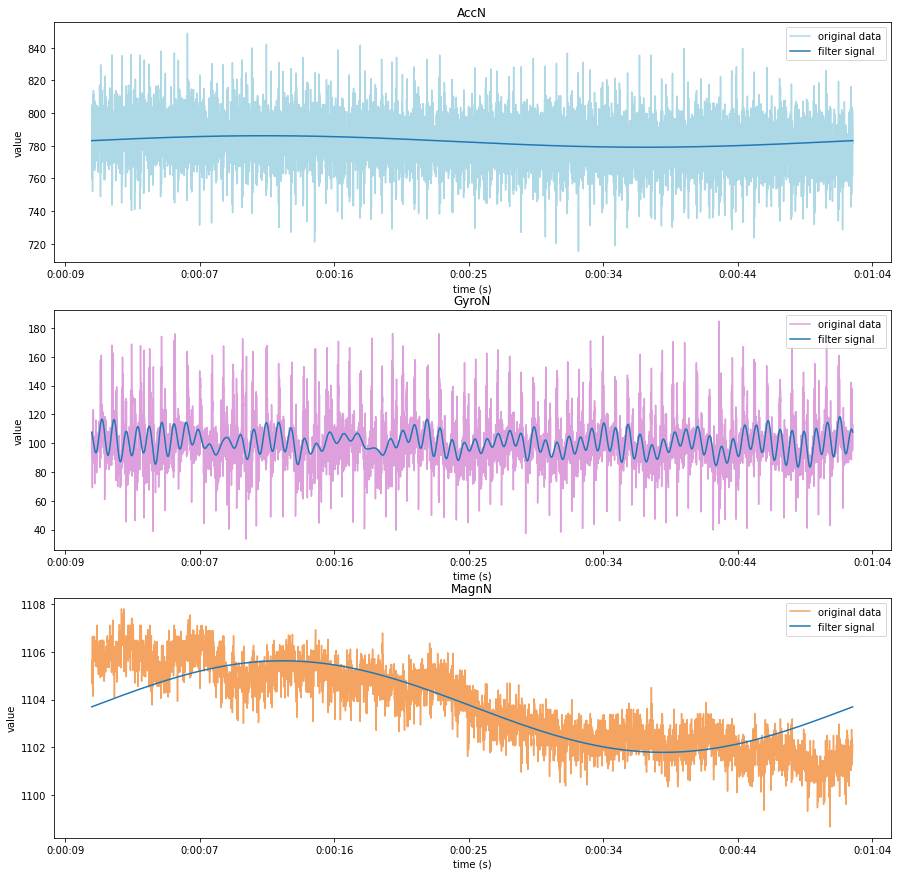

In [125]:
#Function that create the filter thanks to the inverse Fourier transform
def fourier_filter(sig, freqs, peak):
    freq_fft = fftpack.fft(sig)
    freq_fft[np.abs(freqs) - peak > 0 ] = 0 
    filter_sig = fftpack.ifft(freq_fft)
    filter_sig = np.real(filter_sig)
    return filter_sig

filter_sig_acc = fourier_filter(norm_acc, freqs_acc, peak_acc)
filter_sig_gyro = fourier_filter(norm_gyro, freqs_gyro, peak_gyro)
filter_sig_magn = fourier_filter(norm_magn, freqs_magn, peak_magn)


#Function that set the ticks in a format we understand (in seconds)
def format_func(value, tick_number):
    if (value > 2000) & (value < 14000):
        ticks = datetime.fromtimestamp(data_r['Timestamp'][value])
        ticks = ticks - t_min_r
        return ticks
    elif (value >= 14000) | (value <= 2000):
        ticks = datetime.fromtimestamp(data['Timestamp'][value])
        ticks = ticks - t_min
        return ticks

#We overlap the filtered signal with the original one so that we see if there is coherence.
fig, axs = plt.subplots(3, figsize = (15,15))
for i, j, c, f in zip(range(4), ['AccN', 'GyroN', 'MagnN'], ['lightblue', 'plum', 'sandybrown'], [filter_sig_acc, filter_sig_gyro, filter_sig_magn]):
    axs[i].plot(t, data_norm[j], c=c, label="original data")
    axs[i].plot(t, f, label="filter signal")
    axs[i].set_xlabel("time (s)")
    axs[i].set_ylabel("value")
    axs[i].set_title(j)
    axs[i].xaxis.set_major_formatter(plt.FuncFormatter(format_func))
    axs[i].legend(loc="best")

We can that see after the filtering, noises were deleted.    
However, we see that for the filtered signal of the 'MagnN', we don't have a perfect fit, that's why we try to process the goodness of fit to check if the filtered signal fit well the signal.

In [126]:
# RSS = R2 = 1- SSR/TSS
rss1 = 1- (np.sum((filter_sig_acc-norm_acc)**2))/np.sum((np.mean(norm_acc)-norm_acc)**2)
print('rss_acc:',rss1)
rss2 = 1 - (np.sum((filter_sig_gyro-norm_gyro)**2))/np.sum((np.mean(norm_gyro)-norm_gyro)**2)
print('rss_gyro:',rss2)
rss3 = 1 - (np.sum((filter_sig_magn-norm_magn)**2))/np.sum((np.mean(norm_magn)-norm_magn)**2)
print('rss_magn:',rss3)

rss_acc: 0.030646603164671826
rss_gyro: 0.1662790803488161
rss_magn: 0.6311284883334889


In [127]:
#Chi2
print(stats.chisquare(norm_acc, f_exp=filter_sig_acc))
print(stats.chisquare(norm_gyro, f_exp=filter_sig_gyro))
print(stats.chisquare(norm_magn, f_exp=filter_sig_magn))

Power_divergenceResult(statistic=2838.1054752975488, pvalue=1.0)
Power_divergenceResult(statistic=27858.654299626247, pvalue=0.0)
Power_divergenceResult(statistic=11.086071692805834, pvalue=1.0)


We tried to explain our result with goodness of fit, but we realized that with large datasets (11312 data), the chi2 or RSS tests are not performing.

3.b - Choose the appropriate Lowpass/Bandpass/Highpass filter.

First, let's choose the order for the different filters. To be sure that the filter is gonna fit our Fourier signal, we decide to plot our Fourier signal with different order filters.



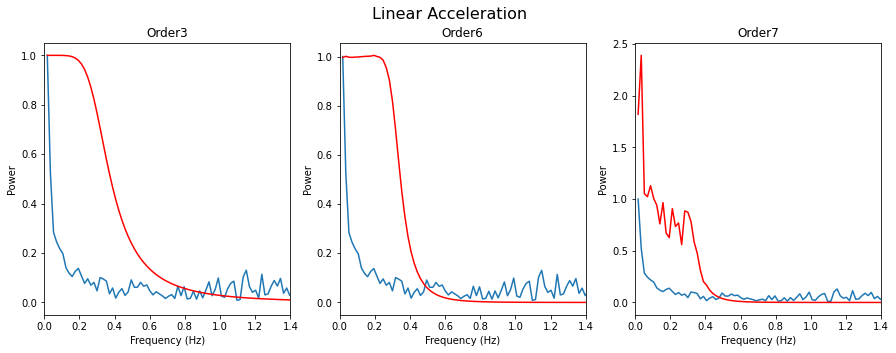

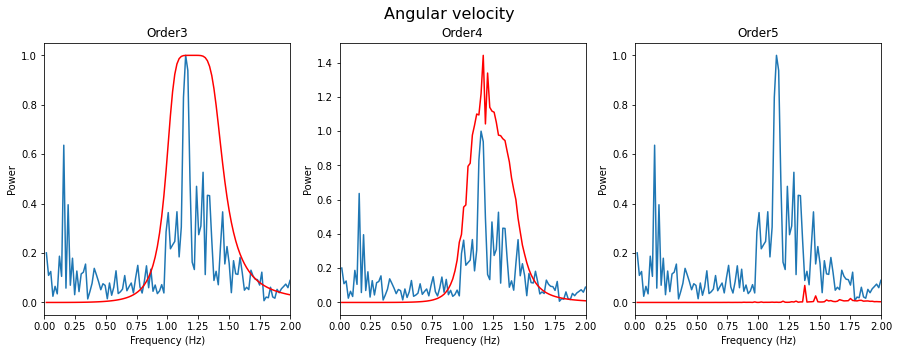

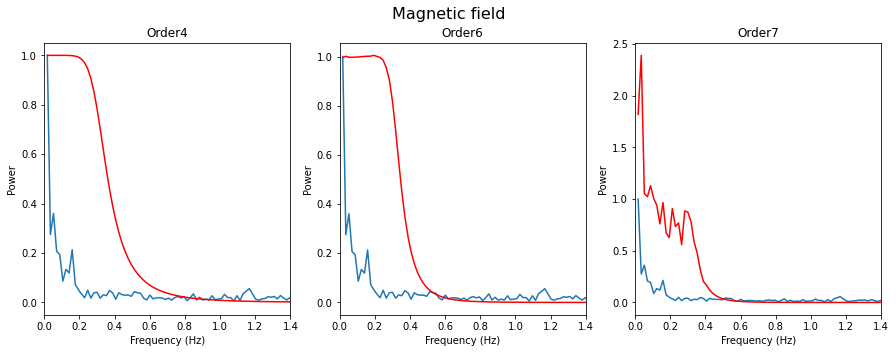

In [286]:
# Pass band
def butter_bandpass(lowcut, highcut, fs, order):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype="band")
    return b, a

# Low pass
def butter_lowpass(cutoff, fs, order):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

fs = 200     #Sampling frequency based on config file
cutoff_acc = 0.3
lowcut = 1
highcut = 1.4
cutoff_magn = 0.3
cutoff_gyro = [lowcut, highcut]


fig, axs = plt.subplots(1,3, figsize=(15, 5))
fig.suptitle('Linear Acceleration',fontsize=16)
for i, order in zip(range(4), [3, 6, 7]):
    b, a = butter_lowpass(cutoff_acc, fs, order=order)
    w, h = freqz(b, a, worN=len(fourier_acc['freq'])) #Compute the frequency repsonse of the filter
    axs[i].plot(fourier_acc['freq'], fourier_acc['powes']/fourier_acc['powes'].abs().max())
    axs[i].plot(fourier_acc['freq'], np.abs(h), 'r', label="Order"+str(order))
    axs[i].set_title("Order"+str(order))
    axs[i].set_xlim(0,1.4)
    axs[i].set_xlabel('Frequency (Hz)')
    axs[i].set_ylabel('Power')
    
#print(fourier_acc['freq'])
fig, axs = plt.subplots(1,3, figsize=(15, 5))
fig.suptitle('Angular velocity',fontsize=16)
for i, order in zip(range(4), [3, 4, 5]):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    w, h = freqz(b, a, worN=len(fourier_acc['freq']))#Compute the frequency repsonse of the filter
    axs[i].plot(fourier_gyro['freq'], fourier_gyro['powes']/fourier_gyro['powes'].abs().max())
    axs[i].plot(fourier_gyro['freq'], np.abs(h), 'r', label="Order"+str(order))
    axs[i].set_title("Order"+str(order))
    axs[i].set_xlim(0,2)
    axs[i].set_xlabel('Frequency (Hz)')
    axs[i].set_ylabel('Power')
    
fig, axs = plt.subplots(1,3, figsize=(15, 5))
fig.suptitle('Magnetic field',fontsize=16)
for i, order in zip(range(4), [4, 6, 7]):
    b, a = butter_lowpass(cutoff_magn, fs, order=order)
    w, h = freqz(b, a, worN=len(fourier_acc['freq']))#Compute the frequency repsonse of the filter
    axs[i].plot(fourier_magn['freq'], fourier_magn['powes']/fourier_magn['powes'].abs().max())
    axs[i].plot(fourier_magn['freq'], np.abs(h), 'r', label="Order"+str(order))
    axs[i].set_title("Order"+str(order))
    axs[i].set_xlim(0,1.4)
    axs[i].set_xlabel('Frequency (Hz)')
    axs[i].set_ylabel('Power')




As we can see, for the linear acceleration, the order 6 is more precise than the order 3 whereas the order 7 is not even following the lowpass curve.
For the angular velocity, the order 3 is the one that allow the peak frequency to be kept. 
Finally, for the magnetic field, the order 6 let the low frequencies (where there is the peak) pass with the most precision. 

[ 2394  2395  2396 ... 13703 13704 13705]


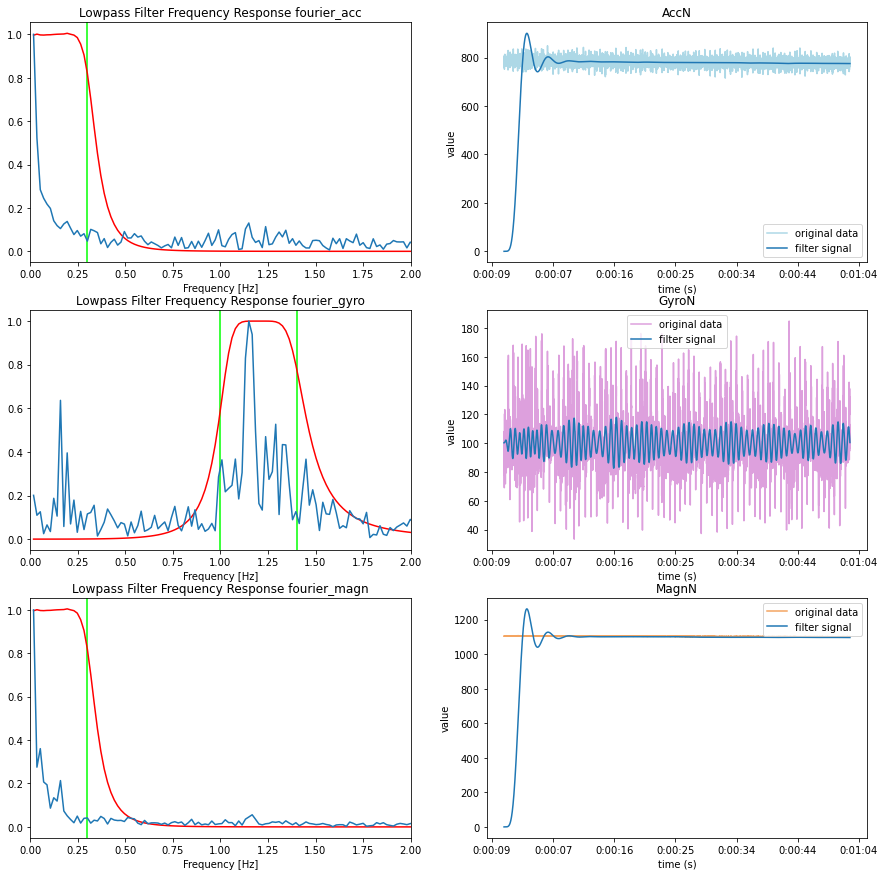

In [129]:
# Function that apply the Low pass filter to the data
def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

# Function that apply the band pass filter to the data
def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y + np.mean(data)


t = np.arange(data_norm.index.min(), data_norm.index.max()+1, 1)
print(t)

orders = [6,3,6]
comment=['AccN', 'GyroN', 'MagnN']
signals = [norm_acc,norm_gyro,norm_magn]
colors = ['lightblue', 'plum', 'sandybrown']
fouriers = [fourier_acc,fourier_gyro,fourier_magn]
tit = ['fourier_acc','fourier_gyro','fourier_magn']
cutoffs = [cutoff_acc,cutoff_gyro,cutoff_magn]


fig, axs = plt.subplots(3,2, figsize = (15,15))
for i in range(3):
    powes_norm = fouriers[i]['powes']/fouriers[i]['powes'].abs().max()
    if i==1:#(Signal = gyro -> bandpass)
        b, a = butter_bandpass(cutoffs[i][0],cutoffs[i][1], fs, orders[i])
        #Filtering through bandpass
        bandpass = butter_bandpass_filter(signals[i], cutoffs[i][0],cutoffs[i][1], fs, orders[i])
        axs[i,0].axvline(cutoffs[i][0], color='lime')
        axs[i,0].axvline(cutoffs[i][1], color='lime')
       
        
    else:
        b, a = butter_lowpass(cutoffs[i], fs, orders[i])
        #Filtering through bandpass
        bandpass = butter_lowpass_filter(signals[i], cutoffs[i], fs, orders[i])
        axs[i,0].axvline(cutoffs[i], color='lime')
        
    # Plotting the frequency response.    
    w, h = freqz(b, a, worN=len(fouriers[i]['freq']))
    axs[i,0].plot(fouriers[i]['freq'], np.abs(h), 'r')
    axs[i,0].plot(fouriers[i]['freq'], powes_norm)
    axs[i,0].set_xlim(0, 2)
    axs[i,0].set_title("Lowpass Filter Frequency Response "+tit[i])
    axs[i,0].set_xlabel('Frequency [Hz]')
        
    axs[i,1].plot(t, data_norm[comment[i]], c=colors[i], label="original data")
    axs[i,1].plot(t, bandpass, label="filter signal")
    axs[i,1].set_xlabel("time (s)")
    axs[i,1].set_ylabel("value")
    axs[i,1].set_title(comment[i])
    axs[i,1].xaxis.set_major_formatter(plt.FuncFormatter(format_func))
    axs[i,1].legend(loc="best")

(1095.0, 1110.0)

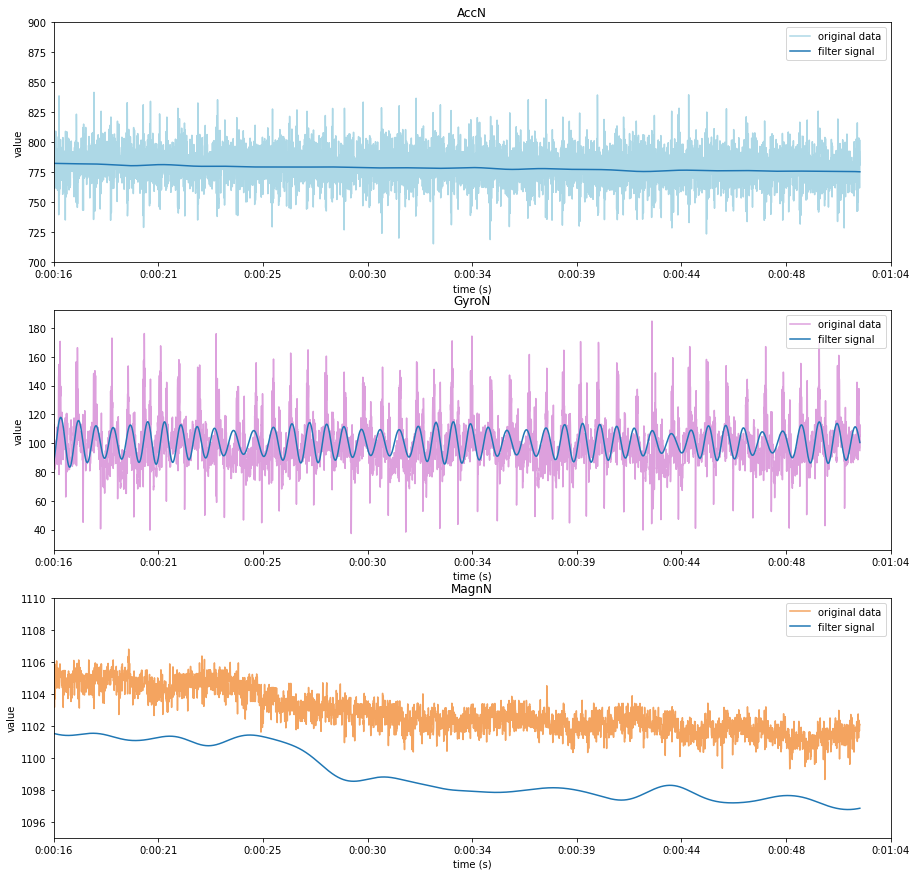

In [381]:
#Zoom without the oscillation 

#Function that set the ticks in a format we understand (in seconds)
def format_func(value, tick_number):
    if (value > 2000) & (value < 14000):
        ticks = datetime.fromtimestamp(data_r['Timestamp'][value])
        ticks = ticks - t_min_r
        return ticks
    elif (value >= 14000) | (value <= 2000):
        ticks = datetime.fromtimestamp(data['Timestamp'][value])
        ticks = ticks - t_min
        return ticks
signal_filtered_bandpass = {}
fig, axs = plt.subplots(3,1, figsize = (15,15))
for i in range(3):   
    powes_norm = fouriers[i]['powes']/fouriers[i]['powes'].abs().max()
    if i==1:#(Signal = gyro -> bandpass)
        b, a = butter_bandpass(cutoffs[i][0],cutoffs[i][1], fs, orders[i])
        #Filtering through bandpass
        bandpass = butter_bandpass_filter(signals[i], cutoffs[i][0],cutoffs[i][1], fs, orders[i])
        
    else:
        b, a = butter_lowpass(cutoffs[i], fs, orders[i])
        #Filtering through bandpass
        bandpass = butter_lowpass_filter(signals[i], cutoffs[i], fs, orders[i])
        
    
    signal_filtered_bandpass[i]= bandpass   #Save the final result in a dictionary variable
    
    axs[i].plot(t, data_norm[comment[i]], c=colors[i], label="original data")
    axs[i].plot(t, bandpass, label="filter signal")
    axs[i].set_xlabel("time (s)")
    axs[i].set_ylabel("value")
    axs[i].set_title(comment[i])
    axs[i].xaxis.set_major_formatter(plt.FuncFormatter(format_func))
    axs[i].legend(loc="best")
    axs[i].set_xlim(6000, 14000)

axs[0].set_ylim(700, 900)
axs[2].set_ylim(1095, 1110)


We zoomed the previous representations to better see the coherence between the filtered signal and the original one. 


In conclusion, we can say that the bandpass filtering is a good method as the filtered fit well the original signal.
We an even compare the gyroN to a sinusoidal function. 

#### PartII of this project:
#### Acquisition time and sampling frequency
For rest of the project we need to be deeper into the time measurments and sample frequency in Timestamp column.

In [484]:
total_time = (t_max-t_min).total_seconds()               #total acquisition time(Sec)
time_sampling_count = data.groupby("Timestamp").size()   #time sampling frequency per second
mean_sampling = np.mean(acq_per_sec)                     #sampling count mean
duration = np.linspace(0,data_reset_index.shape[0]/mean_sampling ,data_reset_index.shape[0])  #starts from 0, goes untill stop number

print(f"Total time: {acquisition_seconds} sec")
print(f"Time sampling count:\n{time_sampling_count}\n")
print(f"Sampling frequency mean: {mean_sampling}")


Total time: 75.0 sec
Time sampling count:
Timestamp
1576222772    224
1576222773    210
1576222774    224
1576222775    210
1576222776    224
             ... 
1576222843    224
1576222844    210
1576222845    224
1576222846    210
1576222847    182
Length: 76, dtype: int64

Sampling frequency mean: 217.18421052631578


#### 3.c - Explore another methods
We can also apply gussian filter to act as a bandpass filter on our signals, Here is gyro fourier signal filtered by this way.

Text(0, 0.5, 'Amplitude')

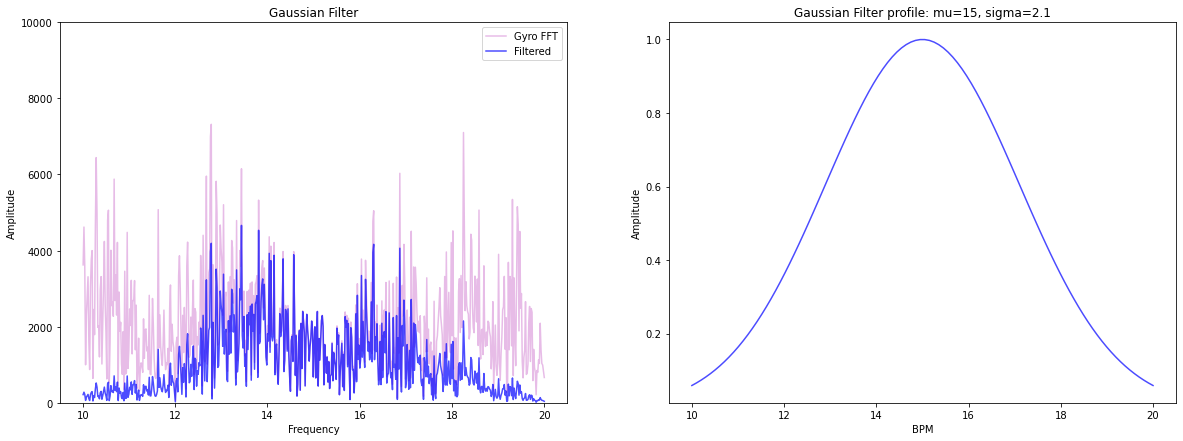

In [463]:
def filter_gaussian(original_ft, mu,sigma): #Gaussian Filter
    filtered_ft = original_ft.copy()
    filtered_ft.loc[(filtered_ft["freq"]< 10) | (filtered_ft["freq"]> 20), "powes"]= 0  #Band-pass filter between 10 and 20 bpm
    filtered_ft["powes"]=filtered_ft["powes"] * stats.norm.pdf(filtered_ft["freq"], mu, sigma) * math.sqrt(2 * math.pi) * sigma #Gaussian filter
    return filtered_ft

cutoff= 15
sigma = 2.1 
fft_gaussian = filter_gaussian(fourier_gyro, cutoff, sigma) #Apply filter


def plot_fft_single(f,title, c,l, i): 
    ff = f[(f['freq']> 10) & (f['freq']< 20)]
    ax[i].plot(ff["freq"], ff["powes"], alpha=0.7, label=l, color=c)
    ax[i].set_title(title)
    ax[i].set_xlabel("Frequency") 
    ax[i].set_ylabel("Amplitude") 
    ax[i].set_ylim(0, 10000)
    ax[i].legend()  

fig, ax = plt.subplots(1, 2, figsize=(20, 7))
plot_fft_single(fourier_gyro, "", colors[1], "Gyro FFT", 0)
plot_fft_single(fft_gaussian, "Gaussian Filter", "blue", "Filtered", 0)   

#Plot gaussian Filter profile
x = np.linspace(10, 20, 100)
ax[1].plot(x, stats.norm.pdf(x, cutoff, sigma)* math.sqrt(2* math.pi)* sigma, alpha=0.7, label="filter profile", color='blue')
ax[1].set_title(f"Gaussian Filter profile: mu={cutoff}, sigma={sigma}")
ax[1].set_xlabel("BPM") 
ax[1].set_ylabel("Amplitude") 


# Metrics:

##### 4.1 Heart Beat Per Minute (BPM)
We have worked with the final results of filter section. The filtered signal is stored in the signal_filtered_bandpass variable. By plotting the output signal, we can see that the normalized gyroscope signal has the best result with the bandpass filter, so we chose this signal for the next work and performed the processing on it.

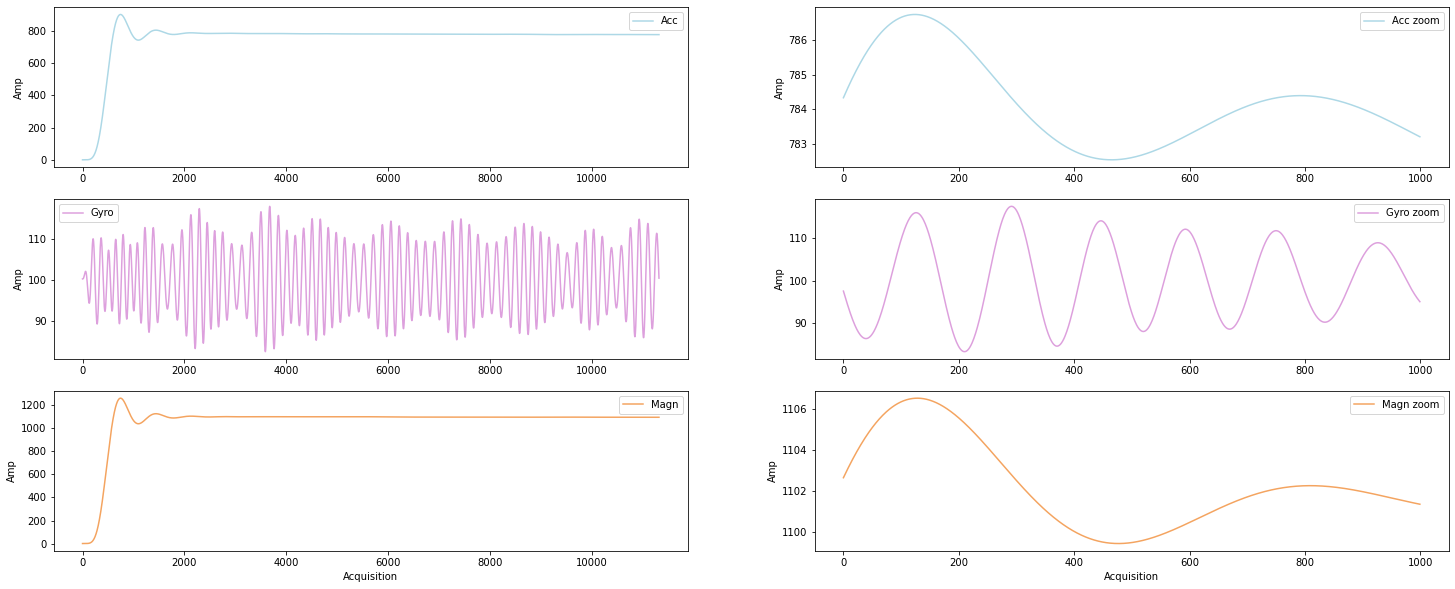

In [393]:
#Using final result of band-pass filter
fig, ax = plt.subplots(3, 2, figsize=(25, 10))
for k,i in zip(signal_filtered_bandpass.keys(),range(3)): 
    name= ""
    if k==0:
        name = "Acc"
    elif k==1:
        name= "Gyro"
    else:
        name= "Magn"
        
    ax[i][0].plot(signal_filtered_bandpass[k], colors[i], label= name)
    ax[i][1].plot(signal_filtered_bandpass[k][2000:3000], colors[i],label= name + " zoom")
    ax[i][0].set_ylabel("Amp")
    ax[i][1].set_ylabel("Amp")
    ax[i][0].legend()
    ax[i][1].legend()
    
ax[2][0].set_xlabel("Acquisition")
ax[2][1].set_xlabel("Acquisition")
plt.show()


It should be noted that the normal resting heart rate range for most healthy adults is between 60 and 100 beats per minute. we used this range for masking our total beats.


The estimation of BPM and HRV by mean and standard deviation is:

Gyro_norm BPM mean:71.53359272520353, HRV : 65.6974991574317 - 77.36968629297537

We can see that this histogram follows the normal distirbution.



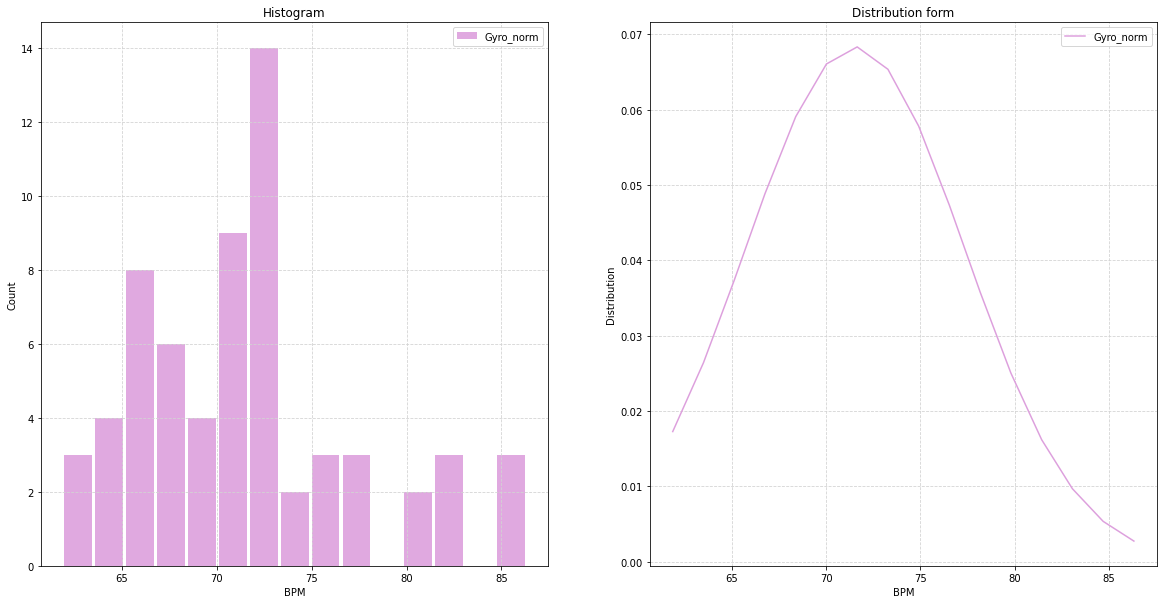

In [500]:
def find_spikes(sig):
    exterma= argrelextrema(np.array(sig), np.greater)[0]
    return exterma

def print_bpm_hist(name, signal, ax):
    global peaks
    peaks = find_spikes(signal)
    beats= 60/(np.diff(peaks)/fs)        #fs= 200 from config file
    mask= (beats>= 60) & (beats<= 100)   #It is a healthy resting heart rate for most healthy adults
    beats = beats[mask]
    
    n, bins, patches = ax[0].hist(x=beats, bins=15, color=colors[1], alpha=0.9, rwidth=0.9, label=name)
    ax[0].legend()
    ax[0].set_title("Histogram")
    ax[0].set_xlabel("BPM")
    ax[0].set_ylabel("Count")
    ax[0].grid(color='lightgray', linestyle='dashed')
    
    mu, sigma = stats.norm.fit(beats)
    best_fit_line = stats.norm.pdf(bins, mu, sigma)
    
    ax[1].plot(bins, best_fit_line, label=name, color=colors[1], alpha=1)
    ax[1].legend()
    ax[1].set_title("Distribution form")
    ax[1].set_xlabel("BPM")
    ax[1].set_ylabel("Distribution")
    ax[1].grid(color='lightgray', linestyle='dashed')
    
    print("\nThe estimation of BPM and HRV by mean and standard deviation is:\n")
    print(f"{name} BPM mean:{mu}, HRV : {mu - sigma} - {mu + sigma}\n") 
    print("We can see that this histogram follows the normal distirbution.\n")
    
peaks     
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
print_bpm_hist("Gyro_norm", signal_filtered_bandpass[1], ax )


##### 4.2 Heart Rate Variability (HRV)
Heart Rate Variability (HRV) is a measure of the variation in time between consecutive heartbeats. It is the beat-to-beat variation in the heart rate. HRV is an important indicator of cardiac health, stress and mental health, exercise capacity and fitness, and also aging.
HRV can be quantified by analyzing the time and frequency domain characteristics of the beat-to-beat intervals such as:
Standard Deviation of the NN Interval (SDNN): It is the standard deviation of all the normal-to-normal (NN) intervals in the time series. It provides a measure of the overall variability of the heart rate.
Root Mean Square of Successive Differences (RMSSD): It is the square root of the mean squared difference between adjacent NN intervals.

In our case, we first found our signal peaks, then we calculated the difference in the time interval between two consecutive beats, and finally we got HRV with the help of RMSSD.


Mean HRV (intended as period variability) calculated on whole dataset: 0.04 s



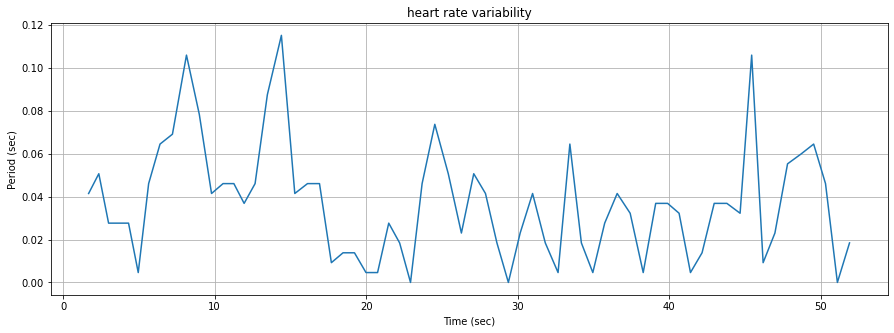

In [502]:
peak_Index = []
periods_diff1 = []
periods_diff2= []

for i in peaks:
    peak_Index.append(duration[i])
    
    
for i in range(len(peak_Index)):
    if(i>0):
        periods_diff1.append(peak_Index[i]- peak_Index[i-1])
        

for i in range(len(periods_diff1)):
    if(i>0):
        periods_diff2.append(abs(periods_diff1[i]-periods_diff1[i-1]))
        
mean_hrv = np.mean(periods_diff2) 
print("\nMean HRV (intended as period variability) calculated on whole dataset:", round(mean_hrv,2), "s\n")

plt.figure(figsize=(15,5))
plt.title("heart rate variability")
plt.plot(gaps[2:],periods_diff2,label='Heart rate variability')
plt.xlabel('Time (sec)')
plt.ylabel('Period (sec)')
plt.grid()
plt.show()


##### Optional - extrapolating the Heart rate with a threshold¶
Let's look at the norm of three components one more time.

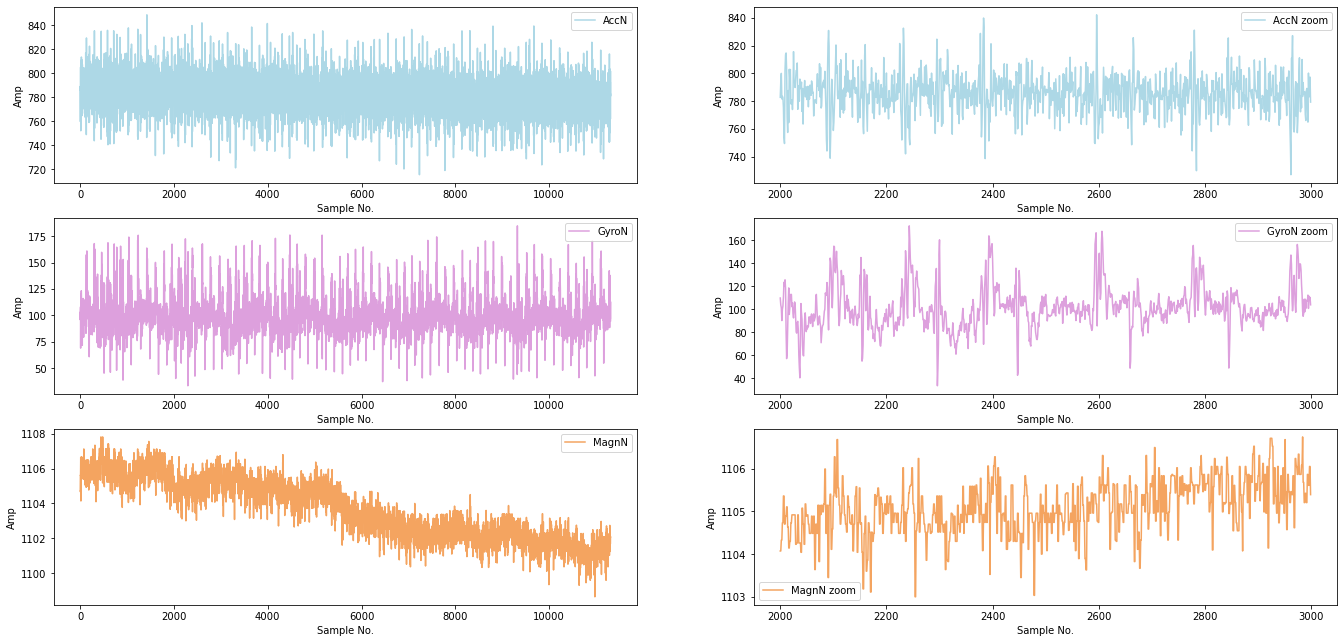

In [229]:

fig, axs = plt.subplots(3, 2,figsize=(23, 11))
for k,i in zip(data_acc.keys(),range(3)):
    ax[i][0]
def plotNorm(ax,data_norm,title,c):
    ax[0].plot(data_norm,color=c,label=title)
    ax[1].plot(data_norm[2000:3000],color=c,label=title+" zoom")
    ax[0].legend()
    ax[1].legend()
    ax[0].set_xlabel("Sample No.")
    ax[0].set_ylabel("Amp")
    ax[1].set_xlabel("Sample No.")
    ax[1].set_ylabel("Amp")
    
plotNorm(axs[0], data_acc['AccN'], 'AccN', colors[0])
plotNorm(axs[1], data_gyro['GyroN'], 'GyroN', colors[1])
plotNorm(axs[2], data_magn['MagnN'], 'MagnN', colors[2])


Then apply a threshold based on the maximum peak of the Gyro signal in a desired range such as [2000:3000].

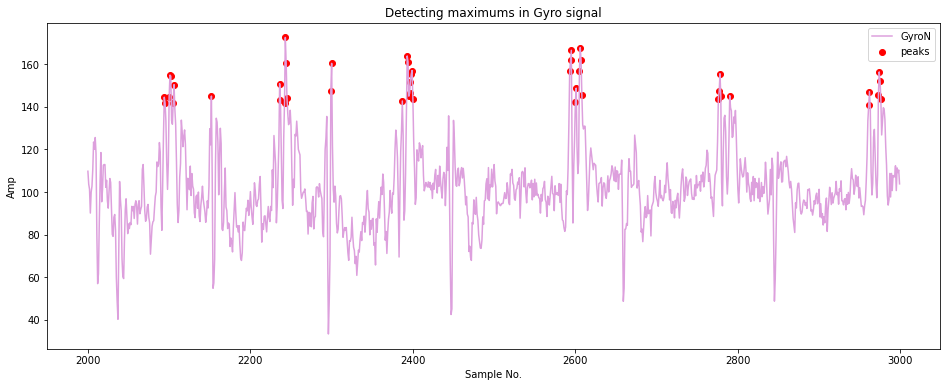

In [440]:
threshold = 140   #Based on the values of Gyro sensor
peaks = np.where(data_gyro['GyroN'] >= threshold)[0] #Filter by threshold
mask= np.where((peaks>2000)&(peaks<3000))[0]
peaks_limited= peaks[mask]

plt.figure(figsize=(16,6))
plt.plot(data_gyro['GyroN'][2000:3000] ,label="GyroN", color=colors[1]) #Select limited point to have a zoomed view
plt.scatter(peaks_limited, data_gyro['GyroN'][peaks_limited], color="red", label="peaks")
plt.title("Detecting maximums in Gyro signal")
plt.xlabel("Sample No.")
plt.ylabel("Amp")
plt.legend()
plt.show()


We can sea that there are some multiple peaks at the same beat, So we decide to group them as follow:

peaks:
[  142   300   457   592   725   779   861   916  1037  1237  1420  1605
  1793  1959  2101  2152  2243  2300  2393  2606  2778  2974  3153  3201
  3326  3377  3499  3558  3667  3833  4000  4163  4318  4472  4531  4628
  4686  4803  5001  5159  5541  5707  5871  6037  6212  6382  6561  6749
  6917  7075  7241  7301  7414  7603  7779  7963  8152  8319  8482  8642
  8702  8813  8988  9324  9357  9523  9685  9845 10033 10235 10411 10580
 10747 10808 10923 11110]


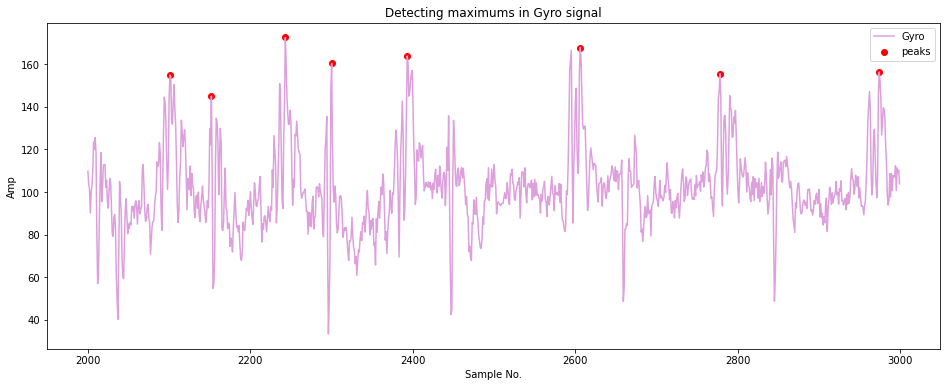

In [441]:
peaks_f=[]
bins=[peaks[0]]
for i in range(1,len(peaks)):
    if peaks[i]-peaks[i-1]<20:
        bins.append(peaks[i])
    else :
        peaks_f.append(bins[np.argmax(data_gyro.loc[bins, "GyroN"])]) #selects the maximum peak between the multiple ones
        bins=[peaks[i]]
peaks_f = np.array(peaks_f)  #Array of the local maximum corresponding to the hart beats
print(f"peaks:\n{peaks_f}")

plt.figure(figsize=(16,6))
plt.plot(data_gyro["GyroN"][2000:3000] ,label="Gyro", color=colors[1])
plt.scatter(peaks_f[np.where((peaks_f>2000)&(peaks_f<3000))[0]],data_gyro["GyroN"][peaks_f[np.where((peaks_f>2000)&(peaks_f<3000))[0]]],color="red",label="peaks")
plt.title("Detecting maximums in Gyro signal")
plt.xlabel("Sample No.")
plt.ylabel("Amp")
plt.legend()
plt.show()

Now we can count the peaks and then estimate the heart beat rate.


Estimated BPM mean : 112.23727150280467, and HRV : 67.38462772020706



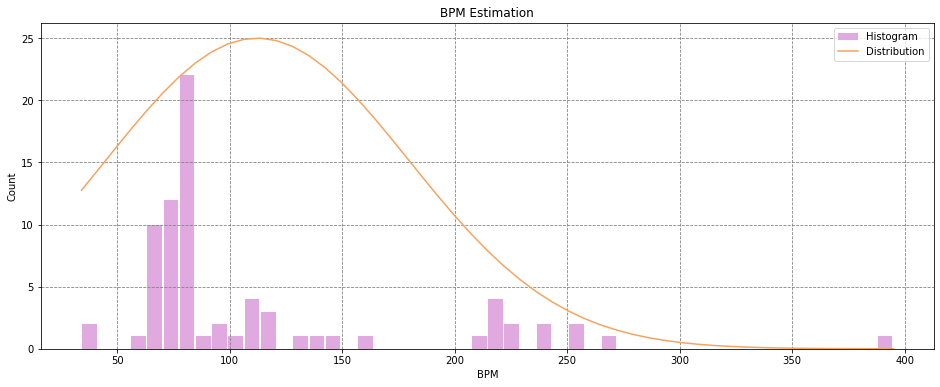

In [445]:
peak_norm = (np.diff(peaks_f)/mean_sampling)
beats= 60/peak_norm
#print(f"peak\n:{beats}")

plt.figure(figsize=(16, 6))
n, bins, patches = plt.hist(x=beats, bins=50, alpha=0.9, rwidth=0.9, color=colors[1], label="Histogram")

mu, sigma = stats.norm.fit(beats)
best_fit_line = stats.norm.pdf(bins, mu, sigma)
max= best_fit_line.max()
plt.plot(bins, 25*best_fit_line/max, color=colors[2], label="Distribution")

print(f"\nEstimated BPM mean : {mu}, and HRV : {sigma}\n") #Estimate BPM and HRV by mean and standard deviation

plt.grid(color='gray', linestyle='dashed')
plt.title("BPM Estimation")
plt.xlabel("BPM")
plt.ylabel("Count")
plt.legend(loc="best")
plt.show()

We omit the far beats to get the better result:


With all above correction on signal we get the normaly distribution around 84 beat

Estimated BPM mean: 84.17996635102205, HRV : 61.76792613619213 - 106.59200656585196



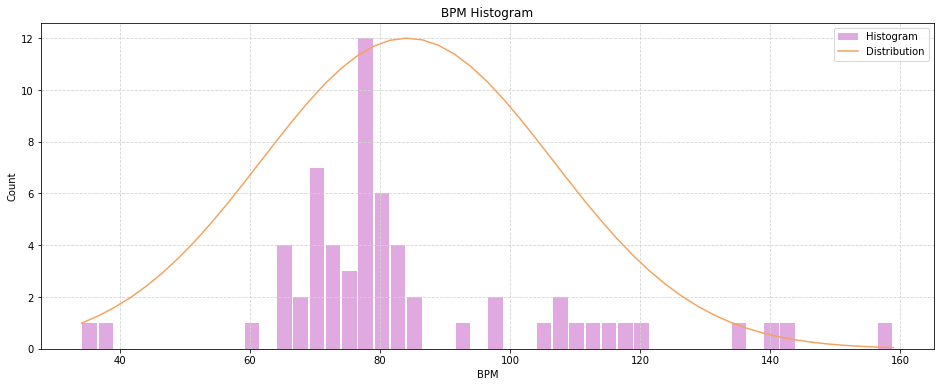

In [498]:
beats = beats[(beats< 200)]
#print(beats)
plt.figure(figsize=(16, 6))
n, bins, patches = plt.hist(x=beats, bins=50, alpha=0.9, rwidth=0.9, color=colors[1], label="Histogram")

mu, sigma = stats.norm.fit(beats)
best_fit_line = stats.norm.pdf(bins, mu, sigma)
max= best_fit_line.max()
plt.plot(bins, 12*best_fit_line/max, color=colors[2], label="Distribution")

print(f"\nWith all above correction on signal we get the normaly distribution around {int(mu)} beat.")
print(f"\nEstimated BPM mean: {mu}, HRV : {mu - sigma} - {mu + sigma}\n") #Estimate BPM and HRV by mean and standard deviation

plt.xlabel("BPM")
plt.ylabel("Count")
plt.title("BPM Histogram")
plt.grid(color='lightgray', linestyle='dashed')
plt.legend()
plt.show()

### Final results
The table below summarizes our estimates for heart beat and heart rate variability in
##### Center_sternum file: 
 Method | Heart beat (BPM) | Std dev (BPM) 
 --- | --- | --- 
 Gyro FT fits| ? | ? 
 Histogram of the maximums filtered (band-pass) signal | 71 | 65-77  
 Threshold on Gyro | 84 | 61-106
